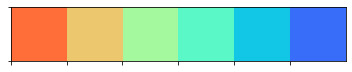

In [1]:
import os, warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import tensorflow as tf
import gc
import tensorflow.keras.backend as K

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import pandas as pd
from pandas import Series
import numpy as np
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import molmap.model

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette("rainbow_r", 6) #PiYG
sns.palplot(color)

from joblib import load, dump
import sklearn.metrics
import scipy
import logging

def r2_score(y_true,y_pred):
    y_mean = np.mean(y_true)
    r2 = 1-sum((y_true-y_pred)**2)/sum((y_mean-y_true)**2)
    return r2
def PCC(y_pred,y_true):
    diff_pred,diff_true=y_pred-np.mean(y_pred),y_true-np.mean(y_true)
    return np.sum(diff_pred*diff_true)/np.sqrt(np.sum(diff_pred**2)*np.sum(diff_true**2))

def from_ic50(ic50, max_ic50=50000.0):
    x = 1.0 - (np.log(np.maximum(ic50, 1e-12)) / np.log(max_ic50))
    return np.minimum(
        1.0,
        np.maximum(0.0, x))
def to_ic50(x, max_ic50=50000.0):
    return max_ic50 ** (1.0 - x)
sample_weight=None,
threshold_nm=500,
max_ic50=50000

读取 blosum62 matrix + pam250 matrix

In [2]:
blosum62 = pd.read_csv('/raid/hly/NEW METHOD EXPT/blosum&pam/data/BLOSUM62.txt', sep='\s')
blosum62 = blosum62.iloc[:-4,:-4]

pam250 = pd.read_csv('/raid/hly/NEW METHOD EXPT/blosum&pam/data/PAM250.csv',index_col=0)

将 blosum62 matrix 以及 pam250 mutation matrix 标准化到 0~1

In [3]:
# aapro归一化
PCP = pd.read_csv('/raid/hly/vaccin/data/cal_CTD/PCP_61.csv', index_col='properties').index
AApro_dic = pd.read_csv('/raid/hly/umap/single_index/AApro_UMAP.csv', header=0,index_col=0)
AA_pro = AApro_dic.loc[PCP].astype('float')
AA_pro = AA_pro.T
AA_pro = ((AA_pro - AA_pro.min()) / (AA_pro.max() - AA_pro.min())).T #归一化

序列相关 aapro,blosum62,pam250 距离矩阵的生成与拼接

In [4]:
def get_3d_feat(seq):
    n = len(seq)

    # 生成理化性质矩阵
    seq_pro = pd.DataFrame(AA_pro[aa] for aa in seq).T
    seq_pro = seq_pro.values[:, :, None]  #二维变成三维（61， n， 1）
    ## 相乘
    mt_pro = np.transpose((seq_pro * np.transpose(seq_pro, [0, 2, 1])), [1, 2, 0])  #**.5   #here!! **0.25
    ## transpose三维转置。（61，n，1）*（61，1，n）=（61，n，n），再转置成（n，n，61）.

    # 生成blosum矩阵
    seq_blosum = np.ones((n,n))
    for i in range(n):
        a = seq[i]
        for j in range(n):
            b = seq[j]
            seq_blosum[i][j] = blosum62.loc[a,b]
    seq_blosum_nor = ((seq_blosum - seq_blosum.min()) / (seq_blosum.max() - seq_blosum.min()))
    seq_blosum_nor = seq_blosum_nor[:, :, np.newaxis]  ##（n，n，1）

    # 生成pam矩阵
    seq_pam = np.ones((n,n))
    for i in range(n):
        a = seq[i]
        for j in range(n):
            b = seq[j]
            seq_pam[i][j] = pam250.loc[a,b]
    seq_pam_nor = ((seq_pam - seq_pam.min()) / (seq_pam.max() - seq_pam.min()))
    seq_pam_nor = seq_pam_nor[:, :, np.newaxis]  ##（n，n，1）

    # 生成序列距离矩阵
    pt_dis = np.ones((n,n))
    for i in range(n):
        for j in range(n):
            pt_dis[i][j] = abs(i-j)
    pt_dis = ((pt_dis - 0) / (n-1 - 0)) ## 归一化（最小值为0，最大值为n-1）
    pt_dis = pt_dis[:, :, np.newaxis]  ##（n，n，1）

    # 改变 理化性质矩阵 的下半部分
    for k in range(mt_pro.shape[2]):
        for i in range(n):
            for j in range(i):
                if k < 60:                                      ##here
                    mt_pro[i,j,k] = (mt_pro[j,i,k] * mt_pro[j,i,k+1])**.5
                else:
                    mt_pro[i,j,k] = (mt_pro[j,i,k] * mt_pro[j,i,0])**.5

    # 将序列距离矩阵与mt合并，并放在第一层
    mt = np.concatenate((pt_dis,seq_blosum_nor,seq_pam_nor,mt_pro),axis = 2)

    x = np.pad(mt, [(0, max_seq_len-n), (0, max_seq_len-n), (0, 0)]) #填充0.令数据集中每条序列对应的Xshape相同。

    return x[ :, :, :, None]

In [5]:
class Inception(tf.keras.layers.Layer):

    def __init__(self, units = 8, strides = 1):
        super(Inception, self).__init__()
        self.conv1 = tf.keras.layers.Conv3D(units, (1,1,1), padding='same', activation = 'relu', strides = strides,kernel_regularizer=tf.keras.regularizers.l2(lamda),
  bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda))
        self.conv2 = tf.keras.layers.Conv3D(units, (3,3,3), padding='same', activation = 'relu', strides = strides,kernel_regularizer=tf.keras.regularizers.l2(lamda),
  bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda))
        self.conv3 = tf.keras.layers.Conv3D(units, (5,5,5), padding='same', activation = 'relu', strides = strides,kernel_regularizer=tf.keras.regularizers.l2(lamda),
  bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda))
        self.concat = tf.keras.layers.Concatenate()

    def call(self, inputs):
        x1 = self.conv1(inputs)
        x2 = self.conv2(inputs)
        x3 = self.conv3(inputs)
        outputs = self.concat([x1, x2, x3])
        return outputs

    def get_config(self): 
        config = {"conv1": self.conv1,"conv2":self.conv2,'conv3':self.conv3}
        base_config = super(Inception, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [6]:
class Model_1(tf.keras.Model):
    def __init__(self):
            super().__init__()
            
            self.Cov_1 = tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_1 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
    #         #here
    #         tf.keras.layers.Conv3D(kn_1, (5,5,5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    # bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda)),
    #         tf.keras.layers.MaxPool3D(), #pool_size = (2,2,2)
    #         #here
            self.Cov_2 =Inception(units=kn_2, strides=1)
            self.MaxPool_2 = tf.keras.layers.MaxPool3D()
            self.Cov_3 = Inception(units=kn_3, strides=1)
            self.GlobalMaxPool = tf.keras.layers.GlobalMaxPooling3D()         #tf.keras.layers.Flatten(),
            self.Dense_1 = tf.keras.layers.Dense(128, activation='relu')
            self.Dense_2 =tf.keras.layers.Dense(32, activation='relu')
            self.Dense_3 =tf.keras.layers.Dense(1)
    
    def call(self, input):
            x = self.Cov_1(input)
            x = self.MaxPool_1(x)
            x = self.Cov_2(x) 
            x = self.MaxPool_2(x)
            x = self.Cov_3(x)
            x = self.GlobalMaxPool(x)
            x = self.Dense_1(x)
            x = self.Dense_2(x)
            x = self.Dense_3(x)
            return x

In [7]:
class Model_2(tf.keras.Model):
    def __init__(self):
            super().__init__()
            
            self.Cov_1 = tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_1 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
            #here
            self.Cov_2 = tf.keras.layers.Conv3D(kn_1, (5,5,5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_2 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
            #here
            self.Cov_3 =Inception(units=kn_2, strides=1)
            self.MaxPool_3 = tf.keras.layers.MaxPool3D()
            self.Cov_4 = Inception(units=kn_3, strides=1)
            self.GlobalMaxPool = tf.keras.layers.GlobalMaxPooling3D()         #tf.keras.layers.Flatten(),
            self.Dense_1 = tf.keras.layers.Dense(128, activation='relu')
            self.Dense_2 =tf.keras.layers.Dense(32, activation='relu')
            self.Dense_3 =tf.keras.layers.Dense(1)
            
    
    def call(self, input):
            x = self.Cov_1(input)
            x = self.MaxPool_1(x)
            #here
            x = self.Cov_2(x)
            x = self.MaxPool_2(x)
            #here
            x = self.Cov_3(x) 
            x = self.MaxPool_3(x)
            x = self.Cov_4(x)
            x = self.GlobalMaxPool(x)
            x = self.Dense_1(x)
            x = self.Dense_2(x)
            x = self.Dense_3(x)
            return x

从MHCflurry训练验证集提取出可使用的数据集。allele['HLA-B_2704','HLA-B_2706','HLA-B_3801']

训练模型

In [8]:
class_name = 'class_1'                                                     #here!
# Train_dir = '/raid/hly/PK-3[2018PLOS]/data/train_data-MID/'+ class_name +'_pre'     
Train_dir = '/raid/hly/PK-4[MHCflurry]/no_mass_spec/data/trainval_MID_otherAllele'
Test_dir = '/raid/hly/PK-3[2018PLOS]/data/PK-3_benchmark_data'

for file in os.listdir(Test_dir):
    
    if file not in os.listdir(Train_dir):
        continue
    Allele = file.split('.')[0]
    df_trainval = pd.read_csv(os.path.join(Train_dir,file))
    df_test = pd.read_csv(os.path.join(Test_dir,file))  
    
    # 创建储存 Allele 结果的文件夹
    task_dir = '/raid/hly/PK-3[2018PLOS]/no_spec_mass/Res'             
    Allele_fold = os.path.join(task_dir,Allele)

    if not os.path.exists(Allele_fold) : 
        os.makedirs(Allele_fold)
        os.makedirs(os.path.join(Allele_fold,'loss'))
        os.makedirs(os.path.join(Allele_fold,'models'))
        os.makedirs(os.path.join(Allele_fold,'results'))
        # os.makedirs(os.path.join(Allele_fold,'fig-loss'))
        # os.makedirs(os.path.join(Allele_fold,'fig-pfm'))
        # os.makedirs(os.path.join(Allele_fold,'fig-pred_true')) 

    # 获得训练集和测试集的最大序列长度
    train_max_seq_len = df_trainval['peptide'].apply(len).max()
    test_max_seq_len = df_test['Description'].apply(len).max()
    max_seq_len = max(train_max_seq_len,test_max_seq_len)

    # 划分训练集与验证集
    kf = StratifiedKFold(
        n_splits= 10,  
        shuffle=True,
        random_state= 2)
    # y_c = df_trainval['Qualitative Measure']
    # for train_idx, valid_idx in kf.split(df_trainval, y_c):
    #     df_train = df_trainval.iloc[train_idx]
    #     df_valid = df_trainval.iloc[valid_idx]

    ### 使用 MHCflurry数据时的划分方式
    # Stratify by both allele and binder vs. nonbinder.
    df_trainval["key"] = [
        "%s_%s" % (
            row.allele,
            "binder" if row.measurement_value <= 500 else "nonbinder")
        for (_, row) in df_trainval.iterrows()
    ]
    
    (train_idx, valid_idx) = next(kf.split(df_trainval, df_trainval.key))
    df_train = df_trainval.iloc[train_idx]
    df_valid = df_trainval.iloc[valid_idx]
    ###  使用 MHCflurry数据时的划分方式

    # 生成 X_train + Y_train 
    X_train_name = os.path.join(Allele_fold, Allele+'_X_train_'+'.data')
    if not os.path.exists(X_train_name) :
        X_train = []
        for seq in df_train['peptide']:
            X_train.append(get_3d_feat(seq))
        X_train = np.stack(X_train)
        dump(X_train, X_train_name)
    else:
        X_train = load(X_train_name)
    X_train = X_train.astype('float32')
    Y_train = df_train['Normalized_QM'].values.reshape(-1, 1) 

    # 生成 X_valid + Y_valid
    X_valid_name = os.path.join(Allele_fold, Allele+'_X_valid_'+'.data')
    if not os.path.exists(X_valid_name) :
        X_valid= []
        for seq in df_valid['peptide']:
            X_valid.append(get_3d_feat(seq))
        X_valid = np.stack(X_valid)
        dump(X_valid, X_valid_name)
    else:
        X_valid = load(X_valid_name)
    X_valid = X_valid.astype('float32')
    Y_valid = df_valid['Normalized_QM'].values.reshape(-1, 1)     
   
   # 生成 X_test + Y_test 
    X_test_name = os.path.join(Allele_fold, Allele+'_X_test_'+'.data')
    if not os.path.exists(X_test_name) :
        X_test = []
        for seq in df_test['Description']:
            X_test.append(get_3d_feat(seq))
        X_test = np.stack(X_test)
        dump(X_test, X_test_name)
    else:
        X_test = load(X_test_name)
    X_test = X_test.astype('float32')
    Y_test = df_test['Normalized_QM'].values.reshape(-1, 1) 

    # 确定参数
    ## 公共参数
    inc = (1,3,5)
    lr = 1e-4
    bs = 32
    ## 特定参数
    if Allele  in ['HLA-A_0202','HLA-A_0201','HLA-A_3002','HLA-A_0203',
                'HLA-B_2705','HLA-A_0301','HLA-B_5301','HLA-A_6802','HLA-A_3301']:   
        df_res = pd.read_csv('/raid/hly/PK-3[2018PLOS]/R3-res/R3_res.csv',index_col=0)    #here

    else : 
        df_res = pd.read_csv('/raid/hly/PK-3[2018PLOS]/R1-res/results_R1.csv',index_col=0)    #here
    
    ks_fir = df_res['kernel_size_1'][Allele]
    ks_fir = eval(ks_fir)
    kn = df_res['kernel_number'][Allele]
    kn = eval(kn)
    kn_1,kn_2,kn_3 = kn[0],kn[1],kn[2]
    lamda = df_res['lamda'][Allele]
   
   #******************************************
    task_name = Allele +'_noMS'

    for ks_fir in [ks_fir]:
        for lamda in [lamda]:

            # continue 情况
            df_done = pd.read_csv(os.path.join(task_dir,'done_list.csv'))
            exists_name = Allele + '_(lr_%s-bs_%s-lam_%s-ks_[%s,%s]-kn_%s)_' %(lr,bs,lamda,ks_fir,inc,kn)
            if (exists_name +'_results.csv') in (df_done['done_file'].values):
                continue

            # 查看目前最佳 R2
            result_file = os.path.join(Allele_fold,'results')
            result_csv = result_file + '/' + task_name + '_results.csv'
            if os.path.exists(result_csv) :
                df_exit_res = pd.read_csv(result_csv)
                best_exit_r2 = df_exit_res['test_r2'][0]
            else:
                best_exit_r2 = -1000

            for n in range(2):
        
                print(exists_name)  
                lr = lr
                patience = 50
                epochs = 300
                loss= tf.keras.losses.log_cosh     #weighted_loss #tf.keras.losses.mean_squared_error 
                batch_size = bs

                df_loss = pd.DataFrame()          
                results = []

                if Allele in ['HLA-A_0202','HLA-A_0201','HLA-A_3002','HLA-A_0203',
                'HLA-B_2705','HLA-A_0301','HLA-B_5301','HLA-A_6802','HLA-A_3301']:   
                    model = Model_2()
                else:
                    model = Model_1()

                opt = tf.keras.optimizers.Adam(lr=lr)
                model.compile(optimizer=opt, loss=loss)

                performance = molmap.model.cbks.Reg3D_EarlyStoppingAndPerformance((X_train, Y_train), 
                                                                (X_valid, Y_valid), 
                                                            patience = patience,
                                                            )

                model.fit(X_train, Y_train, batch_size=batch_size, 
                        epochs = epochs, verbose = 0, shuffle = True, 
                        validation_data = (X_valid, Y_valid), callbacks = [performance]) 
                
                best_epoch = performance.best_epoch
                trainable_params = model.count_params()

                #获取RMSE和R2
                train_rmse,train_mae,train_r,train_r2,train_tau = performance.evaluate(X_train, Y_train)            
                valid_rmse,valid_mae,valid_r,valid_r2,valid_tau = performance.evaluate(X_valid, Y_valid)

                # make prediction
                Y_test_pred = model.predict(X_test)
                df_pred = pd.DataFrame(Y_test_pred.tolist()).rename(columns={0:'Pred_Norm_QM'})
                df_pred['Pred_QM'] = df_pred['Pred_Norm_QM'].apply(to_ic50)
                df_truepred = pd.merge(df_test,df_pred,how='inner',left_index=True,right_index=True)   

                y_true = df_truepred['Normalized_QM']
                y_pred = df_truepred['Pred_Norm_QM']
                test_r2 = r2_score(y_true, y_pred)   
                test_r = PCC(y_true, y_pred)           
       
                if test_r2 >= best_exit_r2 :

                    #储存loss
                    dfl = pd.DataFrame(performance.history)
                    df_loss = df_loss.append(dfl, ignore_index = True)
                    df_loss.to_csv(os.path.join(os.path.join(Allele_fold,'loss'),  task_name +'_loss.csv'))
                
                    # 储存 prediction
                    df_truepred.to_csv(os.path.join(Allele_fold,Allele+'true_pred.csv'))

                    # 计算 tau, auc, f1
                    test_tau = scipy.stats.kendalltau(y_pred, y_true)[0]

                    y_pred_score = from_ic50(y_pred, max_ic50)
                    try:
                        test_auc = sklearn.metrics.roc_auc_score(
                                    y_true <= threshold_nm,
                                    y_pred_score,
                                    sample_weight=sample_weight)
                    except ValueError as e:
                        logging.warning(e)
                        test_auc = np.nan
                    
                    try:
                        test_f1 = sklearn.metrics.f1_score(
                                    y_true <= threshold_nm,
                                    y_pred <= threshold_nm,
                                    sample_weight=sample_weight)
                    except ValueError as e:
                        logging.warning(e)
                        test_f1 = np.nan

                    #整体性结果
                    final_res = {
                                'train_rmse':np.nanmean(train_rmse), 
                                'valid_rmse':np.nanmean(valid_rmse),  
                                # 'train_mse':np.nanmean(train_mse), 
                                # 'valid_mse':np.nanmean(test_mse),                      
                                'train_r2':np.nanmean(train_r2), 
                                'valid_r2':np.nanmean(valid_r2), 
                                'train_mae':np.nanmean(train_mae), 
                                'valid_mae':np.nanmean(valid_mae),
                                'train_r':np.nanmean(train_r), 
                                'valid_r':np.nanmean(valid_r),
                                'train_tau':np.nanmean(train_tau), 
                                'valid_tau':np.nanmean(valid_tau),
                                # 'train_auc':np.nanmean(train_auc), 
                                # 'valid_auc':np.nanmean(valid_auc),
                                'test_r2':np.nanmean(test_r2),
                                'test_r':np.nanmean(test_r),
                                'test_tau':np.nanmean(test_tau),
                                'test_auc':np.nanmean(test_auc),
                                'test_f1' : np.nanmean(test_f1),
                                'trainable params': trainable_params, 
                                'best_epoch': best_epoch,
                                'lr' : lr,
                                'batch_size':bs,
                                'kernel_size_1':ks_fir,
                                'kernel_size_incept': inc,
                                'kernel_number':kn,
                                'lamda' : lamda
                                }

                    results.append(final_res)
                    dfr = pd.DataFrame(results)
                    dfr.to_csv(os.path.join(os.path.join(Allele_fold,'results'),  task_name +'_results.csv'))
                    
                    # 保存模型
                    model.save_weights(os.path.join(os.path.join(Allele_fold,'models'),  task_name +'_model_'+'.h5'))
                    
                    # 删除model
                    del model

                print('*******************************************************')
         

            df_done = pd.read_csv(os.path.join(task_dir,'done_list.csv'))  
            new_donels = df_done['done_file'].append(pd.Series(exists_name +'_results.csv'))
            df_newdone = pd.DataFrame(new_donels,columns=['done_file'])
            df_newdone.to_csv(os.path.join(task_dir,'done_list.csv'))
    
    
    # # 删除缓存
    # del performance
    gc.collect()
    K.clear_session()
    tf.compat.v1.reset_default_graph() # TF graph isn't same as Keras grap



 epoch: 0034, loss: 0.0009 - val_loss: 0.0097; rmse: 0.0247 - rmse_val: 0.1365;  r2: 0.9886 - r2_val: 0.6524; mae: 0.0167 - mae_val: 0.0962; r: 0.9956 - r_val: 0.8185;tau: 0.8424 - tau_val: 0.5816                                                                                                    
 epoch: 0035, loss: 0.0008 - val_loss: 0.0099; rmse: 0.0249 - rmse_val: 0.1387;  r2: 0.9884 - r2_val: 0.6408; mae: 0.0168 - mae_val: 0.0966; r: 0.9947 - r_val: 0.8065;tau: 0.8411 - tau_val: 0.5820                                                                                                    
 epoch: 0036, loss: 0.0008 - val_loss: 0.0098; rmse: 0.0265 - rmse_val: 0.1377;  r2: 0.9869 - r2_val: 0.6462; mae: 0.0173 - mae_val: 0.0960; r: 0.9935 - r_val: 0.8106;tau: 0.8341 - tau_val: 0.5817                                                                                                    
 epoch: 0037, loss: 0.0008 - val_loss: 0.0095; rmse: 0.0251 - rmse_val: 0.1352;  r2: 0.9882 - r2_val: 0.6591;

*******************************************************
HLA-B_5301_(lr_0.0001-bs_32-lam_1e-06-ks_[(9, 9, 13),(1, 3, 5)]-kn_(96, 64, 128))_
 epoch: 0001, loss: 0.0393 - val_loss: 0.0340; rmse: 0.2596 - rmse_val: 0.2582;  r2: -0.0361 - r2_val: -0.0358; mae: 0.2226 - mae_val: 0.2144; r: 0.1671 - r_val: 0.1502;tau: 0.1126 - tau_val: 0.1064                                                                                                    
 epoch: 0002, loss: 0.0331 - val_loss: 0.0316; rmse: 0.2498 - rmse_val: 0.2516;  r2: 0.0401 - r2_val: 0.0160; mae: 0.2017 - mae_val: 0.1991; r: 0.4288 - r_val: 0.4241;tau: 0.2756 - tau_val: 0.2798                                                                                                    
 epoch: 0003, loss: 0.0300 - val_loss: 0.0278; rmse: 0.2354 - rmse_val: 0.2337;  r2: 0.1483 - r2_val: 0.1513; mae: 0.1995 - mae_val: 0.1930; r: 0.5044 - r_val: 0.5006;tau: 0.3332 - tau_val: 0.3302                                                                     

*******************************************************
HLA-B_5301_(lr_0.0001-bs_32-lam_1e-06-ks_[(9, 9, 13),(1, 3, 5)]-kn_(96, 64, 128))_
 epoch: 0001, loss: 0.0402 - val_loss: 0.0323; rmse: 0.2518 - rmse_val: 0.2516;  r2: 0.0247 - r2_val: 0.0163; mae: 0.2090 - mae_val: 0.2030; r: 0.1801 - r_val: 0.1596;tau: 0.1126 - tau_val: 0.1061                                                                                                    
 epoch: 0002, loss: 0.0319 - val_loss: 0.0369; rmse: 0.2728 - rmse_val: 0.2689;  r2: -0.1443 - r2_val: -0.1240; mae: 0.2327 - mae_val: 0.2240; r: 0.3493 - r_val: 0.3467;tau: 0.2158 - tau_val: 0.2200                                                                                                    
 epoch: 0003, loss: 0.0332 - val_loss: 0.0319; rmse: 0.2494 - rmse_val: 0.2529;  r2: 0.0438 - r2_val: 0.0065; mae: 0.1989 - mae_val: 0.1978; r: 0.4616 - r_val: 0.4596;tau: 0.3008 - tau_val: 0.3024                                                                     

*******************************************************
HLA-B_1501_(lr_0.0001-bs_32-lam_0.001-ks_[(9, 9, 13),(1, 3, 5)]-kn_(48, 32, 64))_
 epoch: 0001, loss: 0.3474 - val_loss: 0.2687; rmse: 0.2769 - rmse_val: 0.2715;  r2: -0.0390 - r2_val: -0.0382; mae: 0.2306 - mae_val: 0.2313; r: -0.0089 - r_val: -0.0191;tau: -0.0164 - tau_val: -0.0191                                                                                                    
 epoch: 0002, loss: 0.2312 - val_loss: 0.1979; rmse: 0.2574 - rmse_val: 0.2514;  r2: 0.1023 - r2_val: 0.1096; mae: 0.2268 - mae_val: 0.2244; r: 0.3703 - r_val: 0.3848;tau: 0.2439 - tau_val: 0.2588                                                                                                    
 epoch: 0003, loss: 0.1772 - val_loss: 0.1558; rmse: 0.2440 - rmse_val: 0.2372;  r2: 0.1929 - r2_val: 0.2072; mae: 0.2108 - mae_val: 0.2080; r: 0.4815 - r_val: 0.4980;tau: 0.3337 - tau_val: 0.3509                                                                  

*******************************************************
HLA-B_1501_(lr_0.0001-bs_32-lam_0.001-ks_[(9, 9, 13),(1, 3, 5)]-kn_(48, 32, 64))_
 epoch: 0001, loss: 0.3521 - val_loss: 0.2773; rmse: 0.2720 - rmse_val: 0.2662;  r2: -0.0029 - r2_val: 0.0014; mae: 0.2335 - mae_val: 0.2326; r: 0.0509 - r_val: 0.0708;tau: 0.0221 - tau_val: 0.0502                                                                                                    
 epoch: 0002, loss: 0.2410 - val_loss: 0.2106; rmse: 0.2819 - rmse_val: 0.2759;  r2: -0.0770 - r2_val: -0.0722; mae: 0.2176 - mae_val: 0.2183; r: 0.3021 - r_val: 0.3212;tau: 0.1961 - tau_val: 0.2279                                                                                                    
 epoch: 0003, loss: 0.1860 - val_loss: 0.1631; rmse: 0.2517 - rmse_val: 0.2452;  r2: 0.1411 - r2_val: 0.1526; mae: 0.2132 - mae_val: 0.2124; r: 0.4334 - r_val: 0.4466;tau: 0.2935 - tau_val: 0.3174                                                                     

*******************************************************


In [9]:
Allele

'HLA-B_1501'